In [1]:
from IPython.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
import os
import pickle
import matplotlib.image as mpimg
import numpy as np
import transformers
import sklearn.metrics
import tensorflow as tf
import tqdm.notebook as tqdm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import shutil

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Load ViT transformer model from huggingface: https://huggingface.co/google/vit-base-patch32-224-in21k

In [4]:
IMAGE_SIZE = 224
shutil.rmtree('test_dataset')
shutil.rmtree('train_dataset')
shutil.rmtree('valid_dataset')

In [5]:
backbone = transformers.TFViTModel.from_pretrained('google/vit-base-patch32-224-in21k')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch32-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


# Dataset preparation

Write a function that transforms images in a folder (train, valid, test) and saves ViT outputs as a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Remember that images are read with values in range `[0, 255]`, but ViT model exppects image values to be in range `[0, 1]`. In addition ViT model expects inputs to have the shape `[N, C, H, W]`, but dataset outputs images with shape `[N, H, W, C]`. Don't forget that transformers models return an object instead of just array of data, so you need to use `pooler_output` field from it.

In [6]:
def prepare_dataset(images_path: str, output_path: str, batch_size: int = 32, shuffle: bool = True) -> None:
    '''Reads images from `image_path`, computes ViT output on them and saves the output with labels to `output_path` as tf.data.Dataset
    
    Arguments:
        image_path: path to read images from,
        output_path: path to save dataset to,
        batch_size: batch_size to use for image processing,
        shuffle: 
    '''
    dataset = tf.keras.utils.image_dataset_from_directory(
        images_path,
        shuffle=shuffle,
        image_size=(224, 224),
        batch_size=batch_size
    )
    
    X, y = [], []
    
    for images, labels in tqdm.tqdm(dataset):
        images = images / 255
        images = tf.transpose(images, [0, 3, 1, 2])
        X.append(backbone.predict(images, verbose=0).pooler_output)
        y.append(labels)
    X = tf.concat(X, axis=0)
    y = tf.concat(y, axis=0)
    X_dataset = tf.data.Dataset.from_tensor_slices(X)
    y_dataset = tf.data.Dataset.from_tensor_slices(y)
    
    tf.data.Dataset.zip((X_dataset, y_dataset)).save(output_path)

Since images never change, we only need to compute ViT output on them once per image. Doing so before the actual model training increases training speed

In [7]:
prepare_dataset('train', 'train_dataset')
prepare_dataset('valid', 'valid_dataset', shuffle=False)
prepare_dataset('test',  'test_dataset',  shuffle=False)

Found 1040 files belonging to 12 classes.


  0%|          | 0/33 [00:00<?, ?it/s]

Found 246 files belonging to 12 classes.


  0%|          | 0/8 [00:00<?, ?it/s]

Found 637 files belonging to 11 classes.


  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
train_dataset = tf.data.Dataset.load('train_dataset')
valid_dataset = tf.data.Dataset.load('valid_dataset')
test_dataset  = tf.data.Dataset.load('test_dataset')

In [9]:
print(f'Number of train images: {len(train_dataset)}; Number of validation images: {len(valid_dataset)}; Number of test images: {len(test_dataset)}')

Number of train images: 1040; Number of validation images: 246; Number of test images: 637


Note the structure of the dataset. Each element is a pair: embedding vector of size 768 and a single class label

In [10]:
train_dataset.element_spec

(TensorSpec(shape=(768,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

# Build classification model

In [11]:
# classes = pickle.load(open('classes.bin', 'rb'))

tf.keras models are built as a graph, see more [here](https://www.tensorflow.org/guide/keras/functional).

First, make an input layer that accepts a vector of type tf.float32 and size 768.

In [12]:
inputs = tf.keras.layers.Input(shape=(768,), dtype=tf.float32,  name='vit_embeddings')

In [13]:
# len(classes)

Add at least one Dense layer, not that the size of the last vector must be equal to the number of classes and have a `softmax` activation

In [14]:
x = tf.keras.layers.Dense(units=450, activation='softmax')(inputs)

Finish constructing the model

In [15]:
model = tf.keras.models.Model(inputs=inputs, outputs=x, name='odnoklassniki_classifictaion_model')

In [16]:
model.summary()

Model: "odnoklassniki_classifictaion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit_embeddings (InputLayer)  [(None, 768)]            0         
                                                                 
 dense (Dense)               (None, 450)               346050    
                                                                 
Total params: 346,050
Trainable params: 346,050
Non-trainable params: 0
_________________________________________________________________


Compile the model. The loss is categorical crossentropy that expects ground truth to be class labels (sparse) rather than one hot vectors. Loss is [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). The only metric is [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy).

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

[Prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) and [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the datasets.

In [18]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.prefetch(tf.data.AUTOTUNE)

In [19]:
BATCH_SIZE = 64

In [20]:
train_dataset = train_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset  = test_dataset.batch(BATCH_SIZE)

Note the structure of the dataset. Each element is a pair of batched tensors: batch of embedding vectors of size 768 and a batch of class labels

In [21]:
train_dataset.element_spec

(TensorSpec(shape=(None, 768), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Prepare a [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the best model while training

In [22]:
MODEL_PATH = 'trained_model'

In [23]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True)]

Train the model

In [24]:
EPOCHS = 100

In [25]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
17/17 [==============================] - 1s 28ms/step - loss: 3.8912 - accuracy: 0.3019 - val_loss: 2.2045 - val_accuracy: 0.4309
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 1.7558 - accuracy: 0.7288 - val_loss: 1.5067 - val_accuracy: 0.8374
Epoch 3/100
17/17 [==============================] - 0s 18ms/step - loss: 1.1862 - accuracy: 0.9048 - val_loss: 1.1234 - val_accuracy: 0.8943
Epoch 4/100
17/17 [==============================] - 0s 18ms/step - loss: 0.8419 - accuracy: 0.9510 - val_loss: 0.8765 - val_accuracy: 0.9146
Epoch 5/100
17/17 [==============================] - 0s 18ms/step - loss: 0.6291 - accuracy: 0.9731 - val_loss: 0.7142 - val_accuracy: 0.9228
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.4910 - accuracy: 0.9817 - val_loss: 0.6019 - val_accuracy: 0.9350
Epoch 7/100
17/17 [==============================] - 0s 18ms/step - loss: 0.3966 - accuracy: 0.9846 - val_loss: 0.5211 - val_accuracy: 0.9309
Epoch 

Evaluate model on the test dataset

In [26]:
model.evaluate(x=test_dataset)

10/10 [==============================] - 0s 3ms/step - loss: 9.6813 - accuracy: 0.0000e+00


[9.681337356567383, 0.0]

Plot confusion matrix on combined valid and test dataset using [ConfusionMatrixDisplay.from_predictions](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions)

In [27]:
combined_dataset = valid_dataset.concatenate(test_dataset)

In [28]:
y_pred = np.argmax(model.predict(combined_dataset), axis=-1)

14/14 [==============================] - 0s 4ms/step


In [29]:
y_true = np.concatenate([i[1] for i in combined_dataset])

The resulting image is VERY LARGY so drawing takes a significant amount of time

In [30]:
# _, ax = plt.subplots(figsize=(150, 150))
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)
# plt.savefig('confusion_matrix.png')
# plt.show()

# Testing on images from the internet

First, make a function that reads an image from disk, resizes and normalizes it. You're only allowed to use tensorflow functions

In [31]:
model = tf.keras.models.load_model('trained_model')

In [32]:
def read_image(path: str) -> tf.Tensor:
    '''Reads image to tf.Tensor
    
    Arguments:
        path: path to read image from
        
    Returns:
        tf.Tensor with shape [H, W, C] and values in range [0, 1]
    
    '''
    img = tf.keras.utils.load_img(path)
    input_arr = tf.keras.utils.img_to_array(img)
    input_arr = input_arr/255
    input_arr = tf.image.resize(input_arr, [224, 224])
    input_arr = tf.convert_to_tensor(input_arr, dtype=tf.float32)
    return input_arr

/# LOAD MODEL FROM DISK

In [33]:
# model.load_weights('weights.h5')

In [34]:
classes = os.listdir('train/')
classes

['Arhip Nikolaev',
 'Arkadii Kasper',
 'Damir Magomedov',
 'Dasha Sorokina',
 'Edik Sushkov',
 'Gleb Karitskii',
 'Ivan Beliaev',
 'Kirill Sannikov',
 'Matvei Beliaev',
 'Minsu',
 'Vlad Peleganchuk',
 'Vova Titkov']

Now make a new model that combines ViT model and the one you just trained. This time your model expects an image tensor of shape `[H, W, C]` and type `tf.float32`. The values `H, W, C` must be replaced with actual values depending on the size of input images

In [35]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='image_input')

Transpose image to fit requirements

In [36]:
x = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]), name='transpose')(inputs)

Get output from ViT model, remember `pooler_output`

In [37]:
x = backbone(x).pooler_output

Get output from the model you trained

In [38]:
x = model(x)

Make evaluation model

In [39]:
evaluation_model = tf.keras.models.Model(inputs=inputs, outputs=x, name='evaluation_model')

Make a function that accepts a path to some image, predicts model output on it and displays image with predicted class caption and probability. Don't forget to use `predict` function and remember that model expects batched input, so data passed to model must be of shape `[1, H, W, C]`

In [40]:
def get_image_class(path: str, ax) -> None:
    '''Gets model output for image specified by `path` and plots the result.
    
    Arguments:
        path: path to image to be tested
    '''
    ax.axis('off')
    image = read_image(path)
    image = tf.expand_dims(image, axis=0)
    pred = evaluation_model.predict(image)
    img = plt.imread(path)
    ax.imshow(img)
    ax.set_title(f'{classes[pred[0].argmax()]} - {pred[0].max()*100}%')

In [41]:
%matplotlib inline

1/1 [==============================] - 2s 2s/step


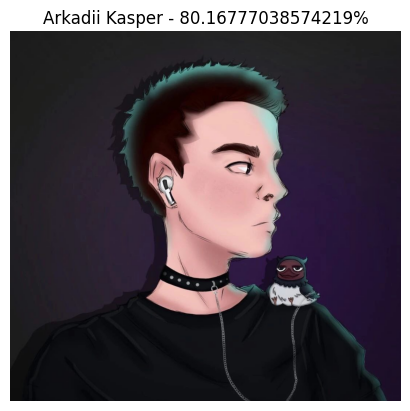

In [42]:
get_image_class('6.jpg', plt.gca())

1/1 [==============================] - 0s 110ms/step


FileNotFoundError: [Errno 2] No such file or directory: '12.jpg'

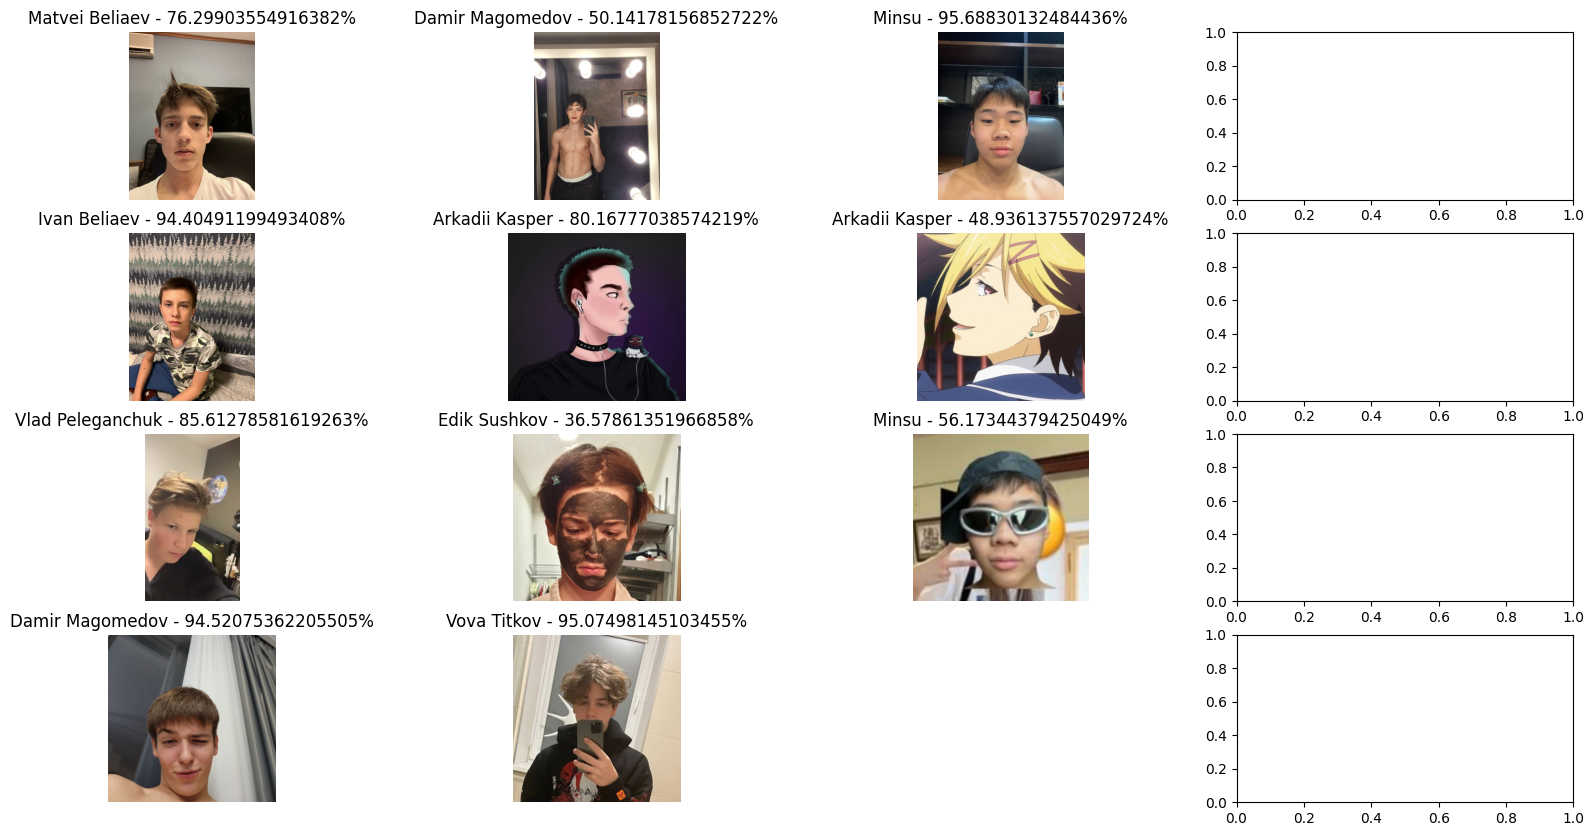

In [48]:
_, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 10))
n = 1
for i in range(4):
    for g in range(4):
        get_image_class(f'{n}.jpg', ax[g][i])
        n+=1